In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
keras = tf.keras

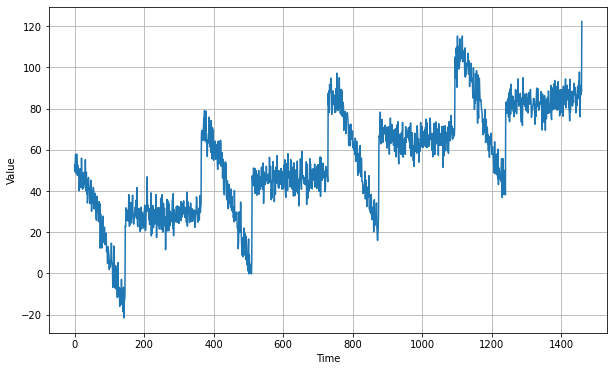

In [3]:
# Creating trend,seasonality and noise 
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

# Now let's generate a time series with a seasonal pattern:s
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

noise_level = 5
noise = white_noise(time, noise_level, seed=42)
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
# Load the dataset
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Linear Model

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 27.2887 - mae: 27.7839 - val_loss: 12.1795 - val_mae: 12.6736
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 9.6416 - mae: 10.1260 - val_loss: 8.2664 - val_mae: 8.7512
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 8.9084 - mae: 9.3972 - val_loss: 8.1128 - val_mae: 8.6016
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 8.7986 - mae: 9.2835 - val_loss: 7.9603 - val_mae: 8.4446
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 8.6248 - mae: 9.1094 - val_loss: 8.2385 - val_mae: 8.7281
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 8.5400 - mae: 9.0277 - val_loss: 7.7538 - val_mae: 8.2408
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 8.4824 - mae: 8.9666 - val_loss: 7.9342 - val_mae: 8.4262
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 8.505

31/31 [==============================] - 0s 5ms/step - loss: 5.5287 - mae: 6.0076 - val_loss: 5.3191 - val_mae: 5.8037
Epoch 64/100
31/31 [==============================] - 0s 4ms/step - loss: 5.4747 - mae: 5.9517 - val_loss: 5.3157 - val_mae: 5.7979
Epoch 65/100
31/31 [==============================] - 0s 4ms/step - loss: 5.5433 - mae: 6.0209 - val_loss: 5.2749 - val_mae: 5.7581
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 5.4780 - mae: 5.9586 - val_loss: 5.4368 - val_mae: 5.9140
Epoch 67/100
31/31 [==============================] - 0s 4ms/step - loss: 5.4574 - mae: 5.9373 - val_loss: 5.2814 - val_mae: 5.7604
Epoch 68/100
31/31 [==============================] - 0s 6ms/step - loss: 5.3601 - mae: 5.8365 - val_loss: 5.6423 - val_mae: 6.1228
Epoch 69/100
31/31 [==============================] - 0s 4ms/step - loss: 5.4029 - mae: 5.8816 - val_loss: 5.2456 - val_mae: 5.7321
Epoch 70/100
31/31 [==============================] - 0s 4ms/step - loss: 5.3945 - mae: 5

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10) # This indicates that where model stop prograssing interuppet and stop working
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 103.4083 - mae: 103.9078 - val_loss: 56.5459 - val_mae: 57.0459
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 13.2006 - mae: 13.6958 - val_loss: 14.3888 - val_mae: 14.8827
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 7.9777 - mae: 8.4626 - val_loss: 7.3631 - val_mae: 7.8477
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 7.4407 - mae: 7.9302 - val_loss: 7.5295 - val_mae: 8.0214
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 7.2711 - mae: 7.7554 - val_loss: 7.1481 - val_mae: 7.6350
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 7.1516 - mae: 7.6358 - val_loss: 7.0660 - val_mae: 7.5512
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 7.0909 - mae: 7.5781 - val_loss: 7.5299 - val_mae: 8.0136
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 

31/31 [==============================] - 0s 5ms/step - loss: 5.2119 - mae: 5.6939 - val_loss: 5.3787 - val_mae: 5.8593
Epoch 64/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1832 - mae: 5.6640 - val_loss: 5.3111 - val_mae: 5.7942
Epoch 65/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1856 - mae: 5.6673 - val_loss: 5.4398 - val_mae: 5.9189
Epoch 66/500
31/31 [==============================] - 0s 4ms/step - loss: 5.2285 - mae: 5.7048 - val_loss: 5.2916 - val_mae: 5.7711
Epoch 67/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1313 - mae: 5.6114 - val_loss: 5.3730 - val_mae: 5.8451
Epoch 68/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1596 - mae: 5.6414 - val_loss: 5.3720 - val_mae: 5.8497
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2026 - mae: 5.6828 - val_loss: 5.2910 - val_mae: 5.7725
Epoch 70/500
31/31 [==============================] - 0s 4ms/step - loss: 5.0999 - mae: 5

Epoch 125/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5343 - mae: 5.0127 - val_loss: 4.8098 - val_mae: 5.2837
Epoch 126/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5667 - mae: 5.0423 - val_loss: 4.7512 - val_mae: 5.2303
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5636 - mae: 5.0396 - val_loss: 4.9367 - val_mae: 5.4159
Epoch 128/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5259 - mae: 5.0030 - val_loss: 4.7929 - val_mae: 5.2685
Epoch 129/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5252 - mae: 5.0004 - val_loss: 4.7031 - val_mae: 5.1824
Epoch 130/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4765 - mae: 4.9541 - val_loss: 5.0227 - val_mae: 5.4993
Epoch 131/500
31/31 [==============================] - 0s 4ms/step - loss: 4.6776 - mae: 5.1615 - val_loss: 4.7182 - val_mae: 5.1993
Epoch 132/500
31/31 [==============================] - 0s 4ms/step - 

31/31 [==============================] - 0s 4ms/step - loss: 4.4035 - mae: 4.8787 - val_loss: 4.9385 - val_mae: 5.4159
Epoch 187/500
31/31 [==============================] - 0s 10ms/step - loss: 4.3541 - mae: 4.8332 - val_loss: 5.0018 - val_mae: 5.4779
Epoch 188/500
31/31 [==============================] - 0s 7ms/step - loss: 4.4348 - mae: 4.9084 - val_loss: 4.6995 - val_mae: 5.1788
Epoch 189/500
31/31 [==============================] - 0s 7ms/step - loss: 4.4260 - mae: 4.9036 - val_loss: 4.5850 - val_mae: 5.0636


# Forcasting

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 4ms/step


In [15]:
lin_forecast.shape

(461,)

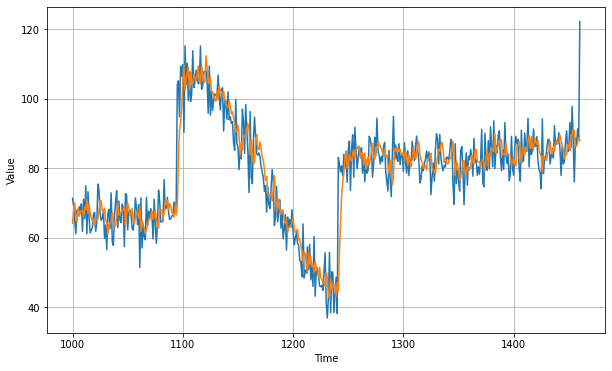

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.011147

# 2 Dense Layer Model Forecasting

In [19]:
# This is for choosing learning rate
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 35.1736 - mae: 35.6720 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 34.7735 - mae: 35.2718 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.2816 - mae: 34.7796 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 33.7293 - mae: 34.2276 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 33.1075 - mae: 33.6063 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 32.4090 - mae: 32.9082 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 31.6233 - mae: 32.1220 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 30.7389 - mae: 31.2375 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 29.7371 - mae: 30.2362 

31/31 [==============================] - 0s 2ms/step - loss: 6.1210 - mae: 6.6054 - lr: 3.9811e-04
Epoch 74/100
31/31 [==============================] - 0s 2ms/step - loss: 5.0889 - mae: 5.5669 - lr: 4.4668e-04
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 5.4411 - mae: 5.9213 - lr: 5.0119e-04
Epoch 76/100
31/31 [==============================] - 0s 2ms/step - loss: 5.8293 - mae: 6.3096 - lr: 5.6234e-04
Epoch 77/100
31/31 [==============================] - 0s 2ms/step - loss: 5.0759 - mae: 5.5560 - lr: 6.3096e-04
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 5.7069 - mae: 6.1849 - lr: 7.0795e-04
Epoch 79/100
31/31 [==============================] - 0s 2ms/step - loss: 7.4957 - mae: 7.9804 - lr: 7.9433e-04
Epoch 80/100
31/31 [==============================] - 0s 2ms/step - loss: 6.1769 - mae: 6.6585 - lr: 8.9125e-04
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 6.3062 - mae: 6.7865 - lr: 0.0010
Epoch 82/

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 48.1470 - mae: 48.6468 - val_loss: 82.9114 - val_mae: 83.4114
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 43.0270 - mae: 43.5257 - val_loss: 75.0423 - val_mae: 75.5423
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 38.2773 - mae: 38.7759 - val_loss: 63.2640 - val_mae: 63.7640
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 28.0502 - mae: 28.5483 - val_loss: 30.6030 - val_mae: 31.1030
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 10.9955 - mae: 11.4824 - val_loss: 8.4576 - val_mae: 8.9392
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 9.1884 - mae: 9.6759 - val_loss: 8.5790 - val_mae: 9.0667
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 8.9899 - mae: 9.4767 - val_loss: 8.5513 - val_mae: 9.0390
Epoch 8/500
31/31 [==============================] - 0s 4ms/step

Epoch 63/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5826 - mae: 6.0629 - val_loss: 5.2672 - val_mae: 5.7430
Epoch 64/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5880 - mae: 6.0716 - val_loss: 5.2018 - val_mae: 5.6759
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5816 - mae: 6.0639 - val_loss: 5.2315 - val_mae: 5.7120
Epoch 66/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5918 - mae: 6.0763 - val_loss: 5.1793 - val_mae: 5.6542
Epoch 67/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5697 - mae: 6.0540 - val_loss: 5.2181 - val_mae: 5.6964
Epoch 68/500
31/31 [==============================] - 0s 4ms/step - loss: 5.5109 - mae: 5.9932 - val_loss: 5.3758 - val_mae: 5.8489
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5212 - mae: 6.0055 - val_loss: 5.3544 - val_mae: 5.8280
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 5.

Epoch 125/500
31/31 [==============================] - 0s 4ms/step - loss: 5.0971 - mae: 5.5752 - val_loss: 4.8661 - val_mae: 5.3475
Epoch 126/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0733 - mae: 5.5503 - val_loss: 4.8630 - val_mae: 5.3392
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0852 - mae: 5.5605 - val_loss: 4.8611 - val_mae: 5.3346
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0771 - mae: 5.5558 - val_loss: 4.8678 - val_mae: 5.3364
Epoch 129/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0927 - mae: 5.5733 - val_loss: 4.8518 - val_mae: 5.3323
Epoch 130/500
31/31 [==============================] - 0s 4ms/step - loss: 5.0690 - mae: 5.5475 - val_loss: 4.8993 - val_mae: 5.3779
Epoch 131/500
31/31 [==============================] - 0s 6ms/step - loss: 5.1212 - mae: 5.6017 - val_loss: 5.2334 - val_mae: 5.7166
Epoch 132/500
31/31 [==============================] - 0s 5ms/step - 

31/31 [==============================] - 0s 5ms/step - loss: 4.8491 - mae: 5.3249 - val_loss: 5.0314 - val_mae: 5.5089
Epoch 187/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8340 - mae: 5.3116 - val_loss: 5.6945 - val_mae: 6.1748
Epoch 188/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8773 - mae: 5.3580 - val_loss: 4.8132 - val_mae: 5.2881
Epoch 189/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8689 - mae: 5.3472 - val_loss: 4.8620 - val_mae: 5.3390
Epoch 190/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8405 - mae: 5.3185 - val_loss: 4.9510 - val_mae: 5.4297
Epoch 191/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8174 - mae: 5.2968 - val_loss: 4.7299 - val_mae: 5.2087
Epoch 192/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8080 - mae: 5.2889 - val_loss: 4.7617 - val_mae: 5.2389
Epoch 193/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8431 -

In [22]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 4ms/step


In [23]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.673598